In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('../Model is used in base paper other than compare one/2. preprocessed WTI dataset/Crude Oil WTI Futures daily.csv')

data.head()


,Date,Close,Open,High,Low,Vol,Changepercent,OVX,VIX,SMA,EMA,DEMA,MACD,Signal,RSI,CCI,Aroon_Up,Aroon_Down,TRIX
0,29-07-2024,79.78,81.30,81.74,79.36,132.25,-1.66,30.82,16.600000,79.227143,78.785521,79.338447,0.709319,0.827026,50.265393,44.513315,56,76,0.170974
1,26-07-2024,81.13,82.40,82.71,80.33,204.95,-1.51,29.77,16.389999,79.233571,79.098118,79.848238,0.837541,0.829129,50.238980,76.528035,96,72,0.168316
2,25-07-2024,82.37,81.58,82.53,80.09,332.16,0.81,26.49,18.459999,79.420000,79.534369,80.562557,1.027373,0.868778,56.945184,76.782026,92,68,0.172012
3,24-07-2024,81.71,81.46,82.23,80.93,298.20,0.86,26.85,18.040001,79.492857,79.824453,80.966956,1.111744,0.917371,52.753780,66.567962,88,64,0.177758
4,23-07-2024,81.01,82.25,82.79,80.51,384.32,-1.69,26.74,14.720000,79.400714,79.982526,81.109691,1.109337,0.955764,46.337308,54.683874,96,60,0.182490


In [2]:
# Convert 'Date' column to datetime and sort the dataset
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data = data.sort_values('Date')



In [3]:
# Use only the 'Close' prices for prediction
close_prices = data['Close'].values.reshape(-1, 1)



In [4]:
# Normalize the data
scaler = StandardScaler()
close_prices_scaled = scaler.fit_transform(close_prices)



In [5]:
# Create X (previous day's price) and y (current day's price)
X = close_prices_scaled[:-1]  # All but the last value
y = close_prices_scaled[1:]   # All but the first value



In [6]:
# Train-test split (80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)



In [7]:
# Initialize and train the SVR model
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train.ravel())



SVR()

In [8]:
# Make predictions with SVR
svr_preds_train = svr_model.predict(X_train)
svr_preds_test = svr_model.predict(X_test)



In [9]:
# Chaining: Using SVR predictions as features for Random Forest
X_train_chain = np.column_stack((X_train, svr_preds_train))
X_test_chain = np.column_stack((X_test, svr_preds_test))



In [10]:
# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_chain, y_train.ravel())



RandomForestRegressor(random_state=42)

In [11]:
# Make predictions with the Random Forest model (chained)
rf_preds = rf_model.predict(X_test_chain)



In [12]:
# Inverse transform the predictions to get the original scale
y_test_inv = scaler.inverse_transform(y_test)
rf_preds_inv = scaler.inverse_transform(rf_preds.reshape(-1, 1))



In [13]:
# Evaluate the model
rmse = root_mean_squared_error(y_test_inv, rf_preds_inv)
mae = mean_absolute_error(y_test_inv, rf_preds_inv)
mape = mean_absolute_percentage_error(y_test_inv, rf_preds_inv)

# Print evaluation metrics
print(f"Root Mean Squared Error (Chained SVR + Random Forest): {rmse}")
print(f"Mean Absolute Error (Chained SVR + Random Forest): {mae}")
print(f"Mean Absolute Percentage Error (Chained SVR + Random Forest): {mape}")



Root Mean Squared Error (Chained SVR + Random Forest): 1.6936748372814077
Mean Absolute Error (Chained SVR + Random Forest): 1.3065407172131143
Mean Absolute Percentage Error (Chained SVR + Random Forest): 0.015597027831927672


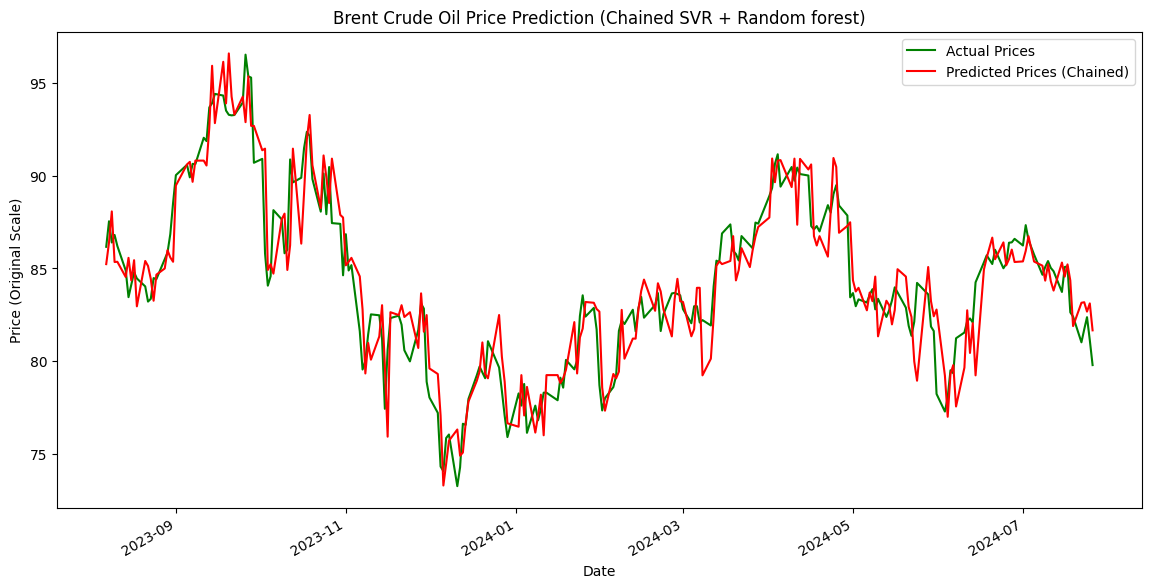

In [14]:
# Plot the actual vs predicted prices (original scale)
plt.figure(figsize=(14, 7))

# Plot actual prices (inverse transformed)
plt.plot(data['Date'].iloc[len(X_train):len(X_train) + len(y_test_inv)], y_test_inv, label='Actual Prices', color='green')

# Plot predicted prices from the chained model
plt.plot(data['Date'].iloc[len(X_train):len(X_train) + len(rf_preds_inv)], rf_preds_inv, label='Predicted Prices (Chained)', color='red')

# Formatting
plt.gcf().autofmt_xdate()
plt.title("Brent Crude Oil Price Prediction (Chained SVR + Random forest)")
plt.xlabel("Date")
plt.ylabel("Price (Original Scale)")
plt.legend()
plt.show()

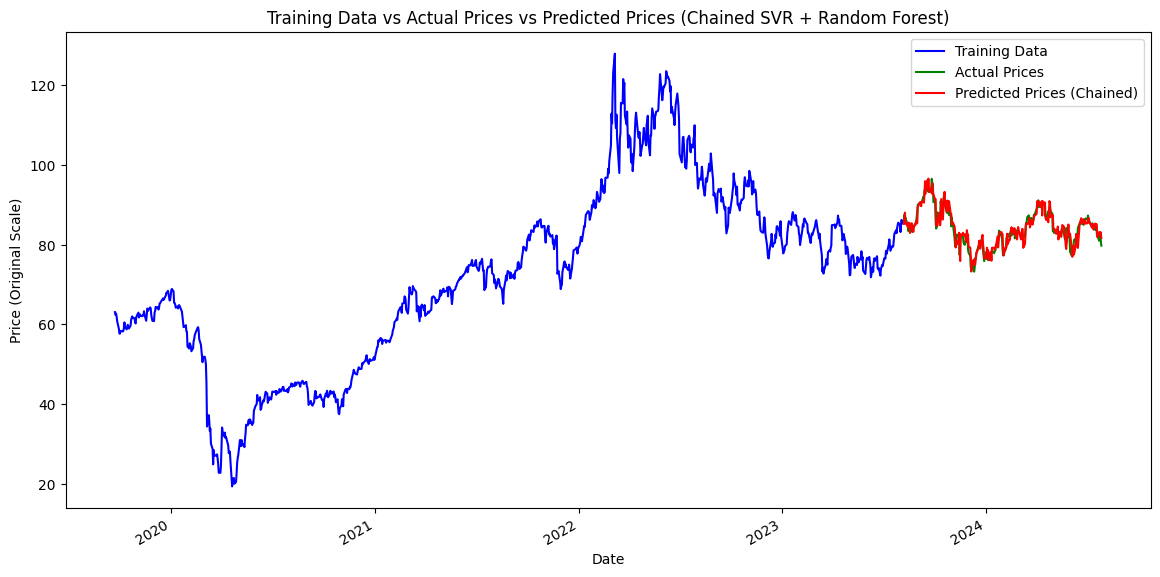

In [15]:
# Inverse transform the training data to get the original scale for comparison
y_train_inv = scaler.inverse_transform(y_train)

# Plot the training data, actual prices, and predicted prices (from the chained model)
plt.figure(figsize=(14, 7))

# Plot training data (inverse transformed)
plt.plot(data['Date'].iloc[:len(X_train)], y_train_inv, label='Training Data', color='blue')

# Plot actual prices (inverse transformed)
plt.plot(data['Date'].iloc[len(X_train):len(X_train) + len(y_test_inv)], y_test_inv, label='Actual Prices', color='green')

# Plot predicted prices (from the chained SVR + Random Forest model)
plt.plot(data['Date'].iloc[len(X_train):len(X_train) + len(rf_preds_inv)], rf_preds_inv, label='Predicted Prices (Chained)', color='red')

# Formatting
plt.gcf().autofmt_xdate()
plt.title("Training Data vs Actual Prices vs Predicted Prices (Chained SVR + Random Forest)")
plt.xlabel("Date")
plt.ylabel("Price (Original Scale)")
plt.legend()
plt.show()
